In [1]:
import geopandas as gpd
from shapely.geometry import box
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib_scalebar.scalebar import ScaleBar
import geodatasets
from pyproj import Transformer

In [6]:
# Dictionary with station coordinates
station_coordinates = {
    'ETA00': (36.843003, 0.454665),
    'ETB00': (36.843124, 0.454613),
    'NNL62': (36.843201, 0.5103490000000001),
    'NWP05': (36.841041, 0.459315),
    'NTA02': (36.842402, 0.456357),
    'STA02': (36.841864, 0.453218),
    'WTA00': (36.841348, 0.454907),
    'WTB00': (36.841464, 0.454863),
    'WTC00': (36.841332, 0.454764),
}

# Define the central point (latitude and longitude)
latitude = 0.4548
longitude = 36.842

# Define the coordinate transformer from EPSG:4326 to EPSG:3857
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

# Convert central point to Web Mercator
central_point_web_mercator = transformer.transform(longitude, latitude)


# Calculate the bounding box for 1 km²
# 0.009 degrees is approximately 1 km
bbox_1km = box(
    longitude - 0.0014,  # min longitude
    latitude - 0.0018,   # min latitude
    longitude + 0.0018,  # max longitude
    latitude + 0.0018    # max latitude
)

# Calculate the bounding box for 3 km² (second subplot)
bbox_3km = box(
    longitude - 0.0135,  # min longitude
    latitude - 0.0135,   # min latitude
    longitude + 0.0135,  # max longitude
    latitude + 0.0135    # max latitude
)

bbox_kenya = box(
    longitude - 7,  # min longitude
    latitude - 7,   # min latitude
    longitude + 7,  # max longitude
    latitude + 7    # max latitude
)

# Create GeoDataFrames for the bounding boxes
bbox_1km_gdf = gpd.GeoDataFrame([1], geometry=[bbox_1km], crs="EPSG:4326")
bbox_3km_gdf = gpd.GeoDataFrame([1], geometry=[bbox_3km], crs="EPSG:4326")
bbox_kenya_gdf = gpd.GeoDataFrame([1], geometry=[bbox_kenya], crs="EPSG:4326")

# Convert the station coordinates to a GeoDataFrame
geometry = [Point(lon, lat) for lon, lat in station_coordinates.values()]
gdf = gpd.GeoDataFrame(station_coordinates.keys(), geometry=geometry, columns=['Station'])
gdf.crs = "EPSG:4326"  # Set the coordinate reference system to WGS84

# Spatial query: filter stations within the 1 km bounding box
stations_within_bbox_1km = gdf[gdf.within(bbox_1km)]
stations_outside_bbox_1km = gdf[~gdf.within(bbox_1km)]

# Reproject the GeoDataFrames to Web Mercator for plotting
stations_within_bbox_1km = stations_within_bbox_1km.to_crs(epsg=3857)
stations_outside_bbox_1km = stations_outside_bbox_1km.to_crs(epsg=3857)
bbox_1km_gdf = bbox_1km_gdf.to_crs(epsg=3857)
bbox_3km_gdf = bbox_3km_gdf.to_crs(epsg=3857)
bbox_kenya_gdf = bbox_kenya_gdf.to_crs(epsg=3857)
gdf = gdf.to_crs(epsg=3857)  # Reproject the full station GeoDataFrame

# Load Kenya boundaries data
# You can use the Natural Earth dataset or similar for country boundaries
world = gpd.read_file('../data/ne_110m_admin_0_countries.shp')

# Reproject Kenya boundaries to Web Mercator
kenya = world.to_crs(epsg=3857)

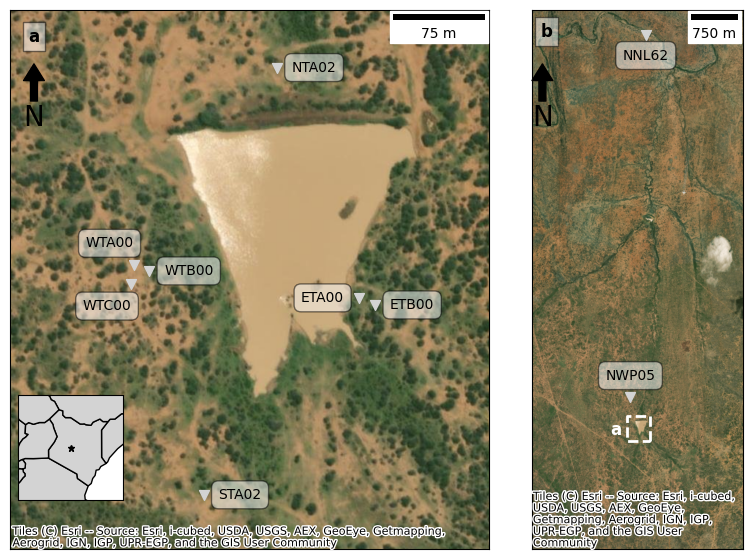

In [24]:

# Plotting the stations on two maps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7), width_ratios=[1.8, 1])

# First subplot: 1 km² area
bbox_1km_gdf.boundary.plot(ax=ax1, edgecolor='blue', linewidth=2,alpha=0)  # Draw bounding box
stations_within_bbox_1km.plot(ax=ax1, color='lightgrey', markersize=50, alpha=1, marker='v')  # Plot stations
for x, y, label in zip(stations_within_bbox_1km.geometry.x, stations_within_bbox_1km.geometry.y, stations_within_bbox_1km['Station']):
    
    if label == 'ETB00':
        ax1.text(x+12, y, label, fontsize=10, ha='left', va='center',bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))
    elif label == 'ETA00':
        ax1.text(x-12, y, label, fontsize=10, ha='right', va='center',bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))
    elif label == 'WTA00':
        ax1.text(x,y+12, label, fontsize=10, ha='right', va='bottom',bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))
    elif label == 'WTC00':
        ax1.text(x, y-12, label, fontsize=10, ha='right', va='top',bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))
    elif label == 'WTB00':
        ax1.text(x+12, y, label, fontsize=10, ha='left', va='center',bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))
    elif label == 'STA02':
        ax1.text(x+12, y, label, fontsize=10, ha='left', va='center',bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))
    elif label == 'NTA02':
        ax1.text(x+12, y, label, fontsize=10, ha='left', va='center',bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))
ctx.add_basemap(ax1, source=ctx.providers.Esri.WorldImagery, zoom=18)
scalebar1 = ScaleBar(1, units="m", dimension="si-length", location='upper right', length_fraction=0.25)
ax1.add_artist(scalebar1)
ax1.set(xticks=[], yticks=[])
ax1.text(0.05, 0.95, 'a', ha='center', va='center', transform=ax1.transAxes, fontsize=12, fontweight='bold', bbox=dict(facecolor='white', alpha=0.5))
# north arrow
arrow_length = 0.1
arrow_x = 0.05
arrow_y = 0.9
ax1.annotate('N', xy=(arrow_x, arrow_y), xytext=(arrow_x, arrow_y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax1.transAxes)

# Inset Plot
# Set up inset axis
inset_ax = fig.add_axes([0.12, 0.18, 0.15, 0.15], zorder=2)  # Adjust position and size as needed
kenya.plot(ax=inset_ax, color='lightgrey', edgecolor='black')
inset_ax.set_xlim(bbox_kenya_gdf.bounds.minx.values[0], bbox_kenya_gdf.bounds.maxx.values[0])
inset_ax.set_ylim(bbox_kenya_gdf.bounds.miny.values[0], bbox_kenya_gdf.bounds.maxy.values[0])
inset_ax.plot(central_point_web_mercator[0], central_point_web_mercator[1], 'k*', markersize=5)
inset_ax.set(xticks=[], yticks=[])

# Second subplot: 3 km² area with the 1 km boundary overlaid
bbox_3km_gdf.boundary.plot(ax=ax2, edgecolor='black', linewidth=2,alpha=0)  # Draw 3 km bounding box
stations_outside_bbox_1km.plot(ax=ax2, color='lightgrey', markersize=50, alpha=1, marker='v')
bbox_1km_gdf.boundary.plot(ax=ax2, edgecolor='white', linewidth=2, ls='--')  # Overlay the 1 km bounding box
ctx.add_basemap(ax2, source=ctx.providers.Esri.WorldImagery, zoom=17)
for x, y, label in zip(stations_outside_bbox_1km.geometry.x, stations_outside_bbox_1km.geometry.y, stations_outside_bbox_1km['Station']):
    if label == 'NWP05':
        ax2.text(x, y+220, label, fontsize=10, ha='center', va='bottom',bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))
    elif label == 'NNL62':
        ax2.text(x, y-220, label, fontsize=10, ha='center', va='top',bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))
scalebar2 = ScaleBar(1, units="m", dimension="si-length", location='upper right', length_fraction=0.25)
ax2.add_artist(scalebar2)
ax2.set(xticks=[], yticks=[])
ax2.text(0.07, 0.96, 'b', ha='center', va='center', transform=ax2.transAxes, fontsize=12, fontweight='bold', bbox=dict(facecolor='white', alpha=0.5))
ax2.text(0.4, 0.22, 'a', ha='center', va='center', transform=ax2.transAxes, fontsize=12, fontweight='bold', color='white')
ax2.annotate('N', xy=(arrow_x, arrow_y), xytext=(arrow_x, arrow_y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax2.transAxes)
# make the room between the subplots smaller
plt.subplots_adjust(wspace=0.001)

plt.show()
